                                       Translated_Review  Sentiment
0      I like eat delicious food. That's I'm cooking ...          0
1        This help eating healthy exercise regular basis          0
3             Works great especially going grocery store          0
4                                           Best idea us          0
5                                               Best way          0
...                                                  ...        ...
64217  I able set range 1cr, scroll space 0-1cr range...          0
64221  Everything old stuff neither clear sold proper...          0
64222  Most ads older many agents ..not much owner po...          0
64223  If photos posted portal load, fit purpose. I'm...          0
64227  I property business got link SMS happy perform...          0

[23998 rows x 2 columns]
                                       Translated_Review  Sentiment
32                    No recipe book Unable recipe book.          1
43     Waste time It n

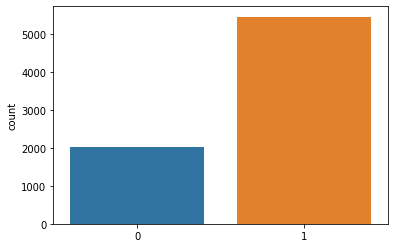

In [22]:
import numpy as np 
import pandas as pd 
import os
import math
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
# 修改路径在这里直接修改即可
Dir = "D:/python_enviroments/PythonCodes/数据挖掘/期末作业/"
pklDir = "D:/python_enviroments/PythonCodes/数据挖掘/期末作业/pkl/"
data=pd.read_csv(Dir + "/google-play-store-apps/googleplaystore_user_reviews.csv",encoding="utf-8")
# 由于只需要判别是不是消极评论，只需要评论和积极性即可
data=pd.concat([data.Translated_Review,data.Sentiment],axis=1)
data.dropna(axis=0,inplace=True) 
data.Sentiment=[0 if i=="Positive" else 1 if i== "Negative" else 2 for i in data.Sentiment]
data.tail()
import re
import nltk
positive_data = data[data.Sentiment == 0]
negative_data = data[data.Sentiment == 1]
neutral_data = data[data.Sentiment == 2]
print(positive_data)
print(negative_data)
print(neutral_data)
# 去除标点符号
def text_standardize(text_data):
    text_list=[]
    list_stopwords=list(set(stopwords.words('english')))
    text=re.sub("[^a-zA-Z]"," ",text_data)
    text=text.lower()
    text=nltk.word_tokenize(text)
    lemma=nltk.WordNetLemmatizer()
    text=[lemma.lemmatize(word) for word in text]
    text=[w for w in text if not w in list_stopwords]
    text=" ".join(text)
    text_list.append(text)
    return text_list

# 计算每个词语出现的次数，并在词语后附上其标签，返回的是字典类型
def get_sorted_word_series(words,number):
    words=nltk.word_tokenize(words)
    count = {}
    for word in words:
        count[word] = count.get(word,0) + 1/number
    items = list(count.items())
    items.sort(key=lambda x:x[1], reverse=True)
    return dict(items)

# 根据测试集划分，去除标点符号，去除停用词，获得词汇表，返回的是字典
def get_vocabulary(reviews,percentage):
    train_words = ''
    for review in reviews[:int(len(reviews)*percentage)]:
        review = text_standardize(review)[-1]
        train_words += (review+' ')
    return get_sorted_word_series(train_words,int(len(reviews)*percentage))

def laplace_public_conditional_probability(positive_dict,negative_dict,neutral_dict):
    positive_probability = []
    negative_probability = []
    neutral_probability = []
    all_dict = [positive_dict,negative_dict,neutral_dict]
    all_probability = [positive_probability,negative_probability,neutral_probability]
    for i in range (3):
        for key in all_dict[i].keys():
            if key in all_dict[(i+1)%3].keys() and key in all_dict[(i+2)%3]:
                temp = [key,all_dict[i][key]/(all_dict[i][key]+all_dict[(i+1)%3][key]+all_dict[(i+2)%3][key])]
                all_probability[i].append(temp)
            elif key in all_dict[(i+1)%3].keys():
                temp = [key,(all_dict[i][key]+1)/(all_dict[i][key]+all_dict[(i+1)%3][key]+3)]
                all_probability[i].append(temp)
            elif key in all_dict[(i+2)%3].keys():
                temp = [key,(all_dict[i][key]+1)/(all_dict[i][key]+all_dict[(i+2)%3][key]+3)]
                all_probability[i].append(temp)
            else:
                all_probability[i].append([key,(all_dict[i][key]+1)/(all_dict[i][key]+3)])
        # 排序
        all_probability[i].sort(key=lambda x:x[1], reverse=False)
        # 用dict将其转换为字典
        all_probability[i] = dict(all_probability[i])
    return all_probability

def judge_emotion(all_data,percentage,dictionary,lamb):
    test_result = []
    # 打开文件，并处理符号和停顿字符
    reviews = all_data.Translated_Review.values
    labels = all_data.Sentiment.values
    count = int(len(reviews)*(1-percentage))
    for review in reviews[int(len(reviews)*(1-percentage)):]:
        review = text_standardize(review)[-1]
        review = nltk.word_tokenize(review)
        # 将ham_score和spam_score置零
        score = [0,0,0]
        # 遍历文件中所有的单词，如果出现在字典中，那么计算他们的得分情况，对e求对数
        # 此处由于被分到垃圾类和非垃圾类概率一样，词频分布一样，故只需累乘即可
        for i in range(3):
            for word in review:
                if word in dictionary[i].keys():
                    score[i]+=math.log(dictionary[i][word])
                else:
                    score[i]+=math.log(lamb)
        positive_score = score[0]
        negative_score = score[1]
        neutral_score = score[2]         
        max_score = max(positive_score,negative_score,neutral_score)
        if positive_score == max_score:
            classify_label = 0
        elif negative_score == max_score:
            classify_label = 1
        else:
            classify_label = 2
            print(review)
      # 如果判断结果一样，那么再test_result中得到一个1的结果，如果不一样则为0
        if classify_label == labels[count]:
            test_result.append(1)
        else:
            test_result.append(0)
        count += 1    
    return test_result
positive_vocabulary = get_vocabulary(positive_data.Translated_Review.values,0.98)
negative_vocabulary = get_vocabulary(negative_data.Translated_Review.values,0.98)
neutral_vocabulary = get_vocabulary(neutral_data.Translated_Review.values,0.98)
print(positive_vocabulary)
print(negative_vocabulary)
print(neutral_vocabulary)
LaplaceProbability = laplace_public_conditional_probability(positive_vocabulary, negative_vocabulary, neutral_vocabulary)
from sklearn.externals import joblib
joblib.dump(LaplaceProbability,pklDir+'/laplace_probability.pkl')
result = judge_emotion(data,0.2,LaplaceProbability,1/100)
print(len(result))
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(result)
print(result)
count = {}
for r in result:
    count[r] = count.get(r,0)+1
print(count)
print("Naive Bayes recall score:",3643/(3643+53+293))
print("Naive Bayes Precision recall score:",3643/(3643+1134))